In [1]:
import findspark
findspark.init('/home/ubuntu/spark-2.1.1-bin-hadoop2.7')
import pyspark
import os
import seaborn as sns
from pyspark.sql import SparkSession
from pyspark.sql.functions import lit
from pyspark.sql.functions import format_number, col
from pyspark.sql.functions import when
import operator
import numpy as np
import pandas as pd

In [2]:
spark = SparkSession.builder.appName('WineQuality').getOrCreate()
sns.set(style="white") #white background style for seaborn plots
sns.set(style="whitegrid", color_codes=True)

In [3]:
df_w = spark.read.csv('White Wine Dataset.csv',header=True,inferSchema=True)
df_r = spark.read.csv('Red Wine Dataset.csv',header=True,inferSchema=True)
df_w.show(5)
df_r.show(5)

+-------------+----------------+-----------+--------------+---------+-------------------+--------------------+-------+----+---------+-------+-------+
|fixed acidity|volatile acidity|citric acid|residual sugar|chlorides|free sulfur dioxide|total sulfur dioxide|density|  pH|sulphates|alcohol|quality|
+-------------+----------------+-----------+--------------+---------+-------------------+--------------------+-------+----+---------+-------+-------+
|          7.0|            0.27|       0.36|          20.7|    0.045|               45.0|               170.0|  1.001| 3.0|     0.45|    8.8|      6|
|          6.3|             0.3|       0.34|           1.6|    0.049|               14.0|               132.0|  0.994| 3.3|     0.49|    9.5|      6|
|          8.1|            0.28|        0.4|           6.9|     0.05|               30.0|                97.0| 0.9951|3.26|     0.44|   10.1|      6|
|          7.2|            0.23|       0.32|           8.5|    0.058|               47.0|           

In [4]:
# "White" presents the white wine while "Red" presnts the red wine
df_w_withcolor = df_w.withColumn("Wine color", lit('White'))
df_w_withcolor.printSchema()
print("White wine count: ", df_w_withcolor.count())

df_r_withcolor = df_r.withColumn("Wine color", lit('Red'))
df_r_withcolor.printSchema()
print("Red wine count: ", df_r_withcolor.count())

root
 |-- fixed acidity: double (nullable = true)
 |-- volatile acidity: double (nullable = true)
 |-- citric acid: double (nullable = true)
 |-- residual sugar: double (nullable = true)
 |-- chlorides: double (nullable = true)
 |-- free sulfur dioxide: double (nullable = true)
 |-- total sulfur dioxide: double (nullable = true)
 |-- density: double (nullable = true)
 |-- pH: double (nullable = true)
 |-- sulphates: double (nullable = true)
 |-- alcohol: double (nullable = true)
 |-- quality: integer (nullable = true)
 |-- Wine color: string (nullable = false)

White wine count:  4898
root
 |-- fixed acidity: double (nullable = true)
 |-- volatile acidity: double (nullable = true)
 |-- citric acid: double (nullable = true)
 |-- residual sugar: double (nullable = true)
 |-- chlorides: double (nullable = true)
 |-- free sulfur dioxide: double (nullable = true)
 |-- total sulfur dioxide: double (nullable = true)
 |-- density: double (nullable = true)
 |-- pH: double (nullable = true)
 |--

In [5]:
# union the df_white and df_red
df_all = df_w_withcolor.unionAll(df_r_withcolor)
df_all.show()

# data set size
print(df_all.count())

# Print schema allows us to visualise the data structure at a high level. 
df_all.printSchema()

# We can also use head to print a specific amount of rows, so we can get a better understanding of the data points. 
# Note that we have to specify 'print' depending on the method we're using. Otherwise it may not show up!
print(df_all.head(1))

+-------------+----------------+-----------+--------------+---------+-------------------+--------------------+-------+----+---------+-------+-------+----------+
|fixed acidity|volatile acidity|citric acid|residual sugar|chlorides|free sulfur dioxide|total sulfur dioxide|density|  pH|sulphates|alcohol|quality|Wine color|
+-------------+----------------+-----------+--------------+---------+-------------------+--------------------+-------+----+---------+-------+-------+----------+
|          7.0|            0.27|       0.36|          20.7|    0.045|               45.0|               170.0|  1.001| 3.0|     0.45|    8.8|      6|     White|
|          6.3|             0.3|       0.34|           1.6|    0.049|               14.0|               132.0|  0.994| 3.3|     0.49|    9.5|      6|     White|
|          8.1|            0.28|        0.4|           6.9|     0.05|               30.0|                97.0| 0.9951|3.26|     0.44|   10.1|      6|     White|
|          7.2|            0.23|  

In [6]:
# We can use the describe method get some general statistics on our data too. 
df_all.toPandas().describe()

fixed acidity  volatile acidity  citric acid  residual sugar  \
count    6497.000000       6497.000000  6497.000000     6497.000000   
mean        7.215307          0.339666     0.318633        5.443235   
std         1.296434          0.164636     0.145318        4.757804   
min         3.800000          0.080000     0.000000        0.600000   
25%         6.400000          0.230000     0.250000        1.800000   
50%         7.000000          0.290000     0.310000        3.000000   
75%         7.700000          0.400000     0.390000        8.100000   
max        15.900000          1.580000     1.660000       65.800000   

         chlorides  free sulfur dioxide  total sulfur dioxide      density  \
count  6497.000000          6497.000000           6497.000000  6497.000000   
mean      0.056034            30.525319            115.744574     0.994697   
std       0.035034            17.749400             56.521855     0.002999   
min       0.009000             1.000000              6.000000     0.987110   
25%       0.038000            17.000000             77.000000     0.992340   
50%       0.047000            29.000000            118.000000     0.994890   
75%       0.065000            41.000000            156.000000     0.996990   
max       0.611000           289.000000            440.000000     1.038980   

                pH    sulphates      alcohol      quality  
count  6497.000000  6497.000000  6497.000000  6497.000000  
mean      3.218501     0.531268    10.491801     5.818378  
std       0.160787     0.148806     1.192712     0.873255  
min       2.720000     0.220000     8.000000     3.000000  
25%       3.110000     0.430000     9.500000     5.000000  
50%       3.210000     0.510000    10.300000     6.000000  
75%       3.320000     0.600000    11.300000     6.000000  
max       4.010000     2.000000    14.900000     9.000000

In [7]:
df_all.show(5)

+-------------+----------------+-----------+--------------+---------+-------------------+--------------------+-------+----+---------+-------+-------+----------+
|fixed acidity|volatile acidity|citric acid|residual sugar|chlorides|free sulfur dioxide|total sulfur dioxide|density|  pH|sulphates|alcohol|quality|Wine color|
+-------------+----------------+-----------+--------------+---------+-------------------+--------------------+-------+----+---------+-------+-------+----------+
|          7.0|            0.27|       0.36|          20.7|    0.045|               45.0|               170.0|  1.001| 3.0|     0.45|    8.8|      6|     White|
|          6.3|             0.3|       0.34|           1.6|    0.049|               14.0|               132.0|  0.994| 3.3|     0.49|    9.5|      6|     White|
|          8.1|            0.28|        0.4|           6.9|     0.05|               30.0|                97.0| 0.9951|3.26|     0.44|   10.1|      6|     White|
|          7.2|            0.23|  

+----------+------------------+
|Wine color|   Average quality|
+----------+------------------+
|     White|  5.87790935075541|
|       Red|5.6360225140712945|
+----------+------------------+



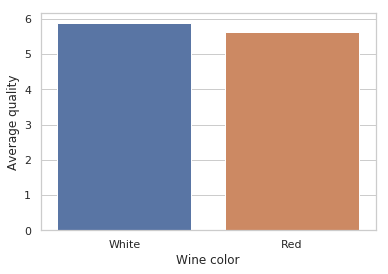

In [8]:
# data exploration
# means by wine color
df_color_avg = df_all.select('Wine color', 'quality').groupBy('Wine color').mean('quality')
df_color_avg = df_color_avg.select(col('Wine color').alias('Wine color'),
                                   col('avg(quality)').alias('Average quality'))
df_color_avg.show()
# df_color_avg.printSchema()

sns.barplot(x='Wine color', y='Average quality', data=df_color_avg.toPandas())

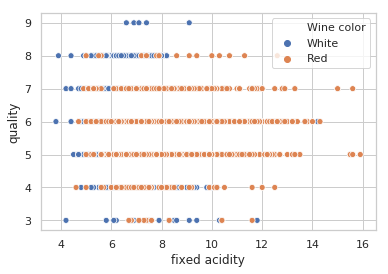

In [9]:
# fixed acidity vs quality
sns.scatterplot(x='fixed acidity', y='quality', data=df_all.toPandas(), hue='Wine color')

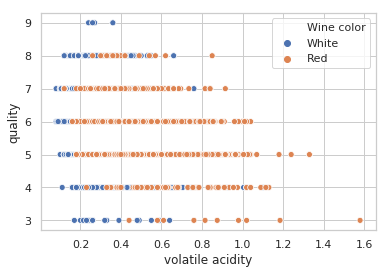

In [10]:
# volatile acidity vs quality
sns.scatterplot(x='volatile acidity', y='quality', data=df_all.toPandas(), hue='Wine color')

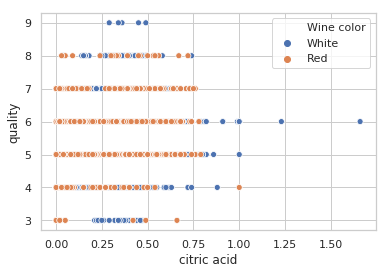

In [11]:
# citric acid vs quality
sns.scatterplot(x='citric acid', y='quality', data=df_all.toPandas(), hue='Wine color')

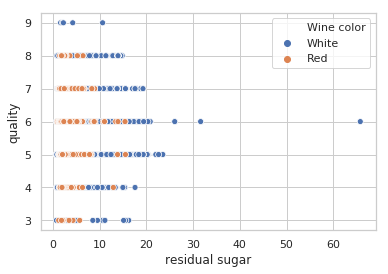

In [12]:
# residual sugar vs quality
sns.scatterplot(x='residual sugar', y='quality', data=df_all.toPandas(), hue='Wine color')

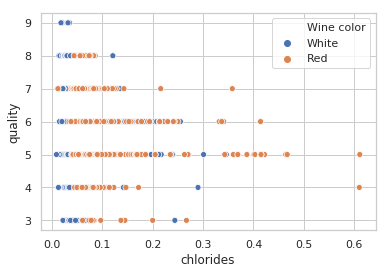

In [13]:
# chlorides vs quality
sns.scatterplot(x='chlorides', y='quality', data=df_all.toPandas(), hue='Wine color')

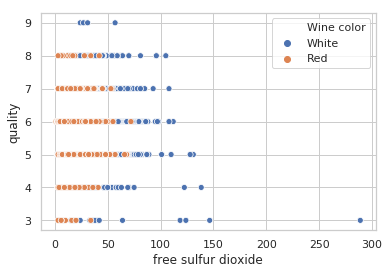

In [14]:
# free sulfur dioxide vs quality
sns.scatterplot(x='free sulfur dioxide', y='quality', data=df_all.toPandas(), hue='Wine color')

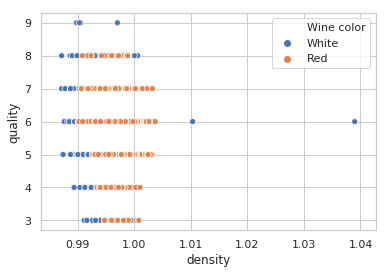

In [15]:
# density vs quality
sns.scatterplot(x='density', y='quality', data=df_all.toPandas(), hue='Wine color')

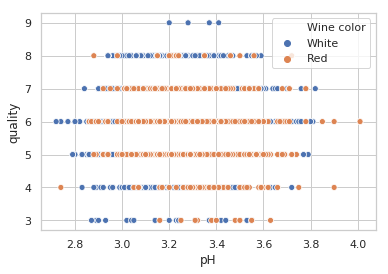

In [16]:
# pH vs quality
sns.scatterplot(x='pH', y='quality', data=df_all.toPandas(), hue='Wine color')

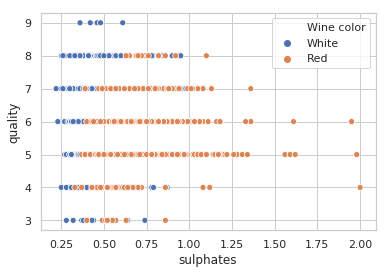

In [17]:
# sulphates vs quality
sns.scatterplot(x='sulphates', y='quality', data=df_all.toPandas(), hue='Wine color')

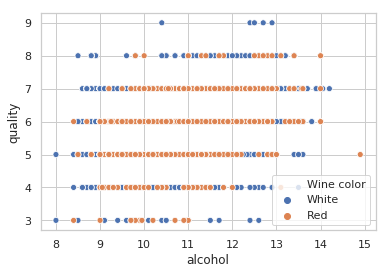

In [18]:
# alcohol vs quality
sns.scatterplot(x='alcohol', y='quality', data=df_all.toPandas(), hue='Wine color')

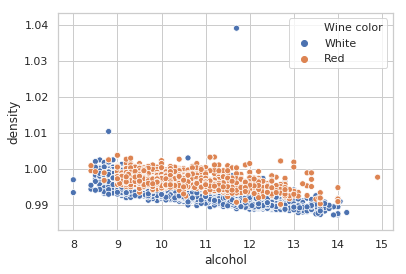

In [19]:
# alcohol vs density
sns.scatterplot(x='alcohol', y='density', data=df_all.toPandas(), hue='Wine color')

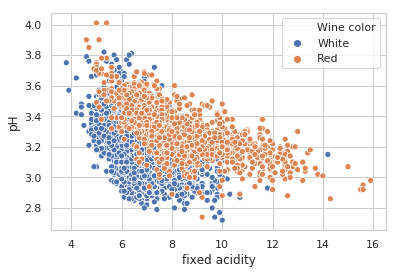

In [20]:
# fixed acidity vs pH
sns.scatterplot(x='fixed acidity', y='pH', data=df_all.toPandas(), hue='Wine color')

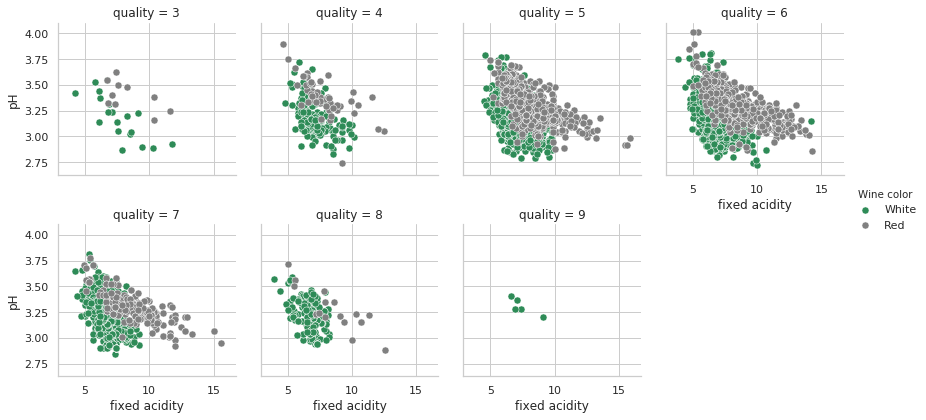

In [21]:
# scatter fixed acidity vs pH
import matplotlib.pyplot as plt
pal = {'White':"seagreen", 'Red':"gray"}
kws = dict(s=50, linewidth=.5, edgecolor="w")
g = sns.FacetGrid(df_all.toPandas(), col="quality", hue="Wine color", palette=pal, hue_order=['White', 'Red'], col_wrap=4)
g = (g.map(plt.scatter, "fixed acidity", "pH", **kws).add_legend())

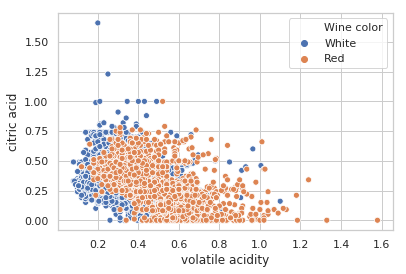

In [22]:
# citric acid vs volatile acidity
sns.scatterplot(x='volatile acidity', y='citric acid', data=df_all.toPandas(), hue='Wine color')

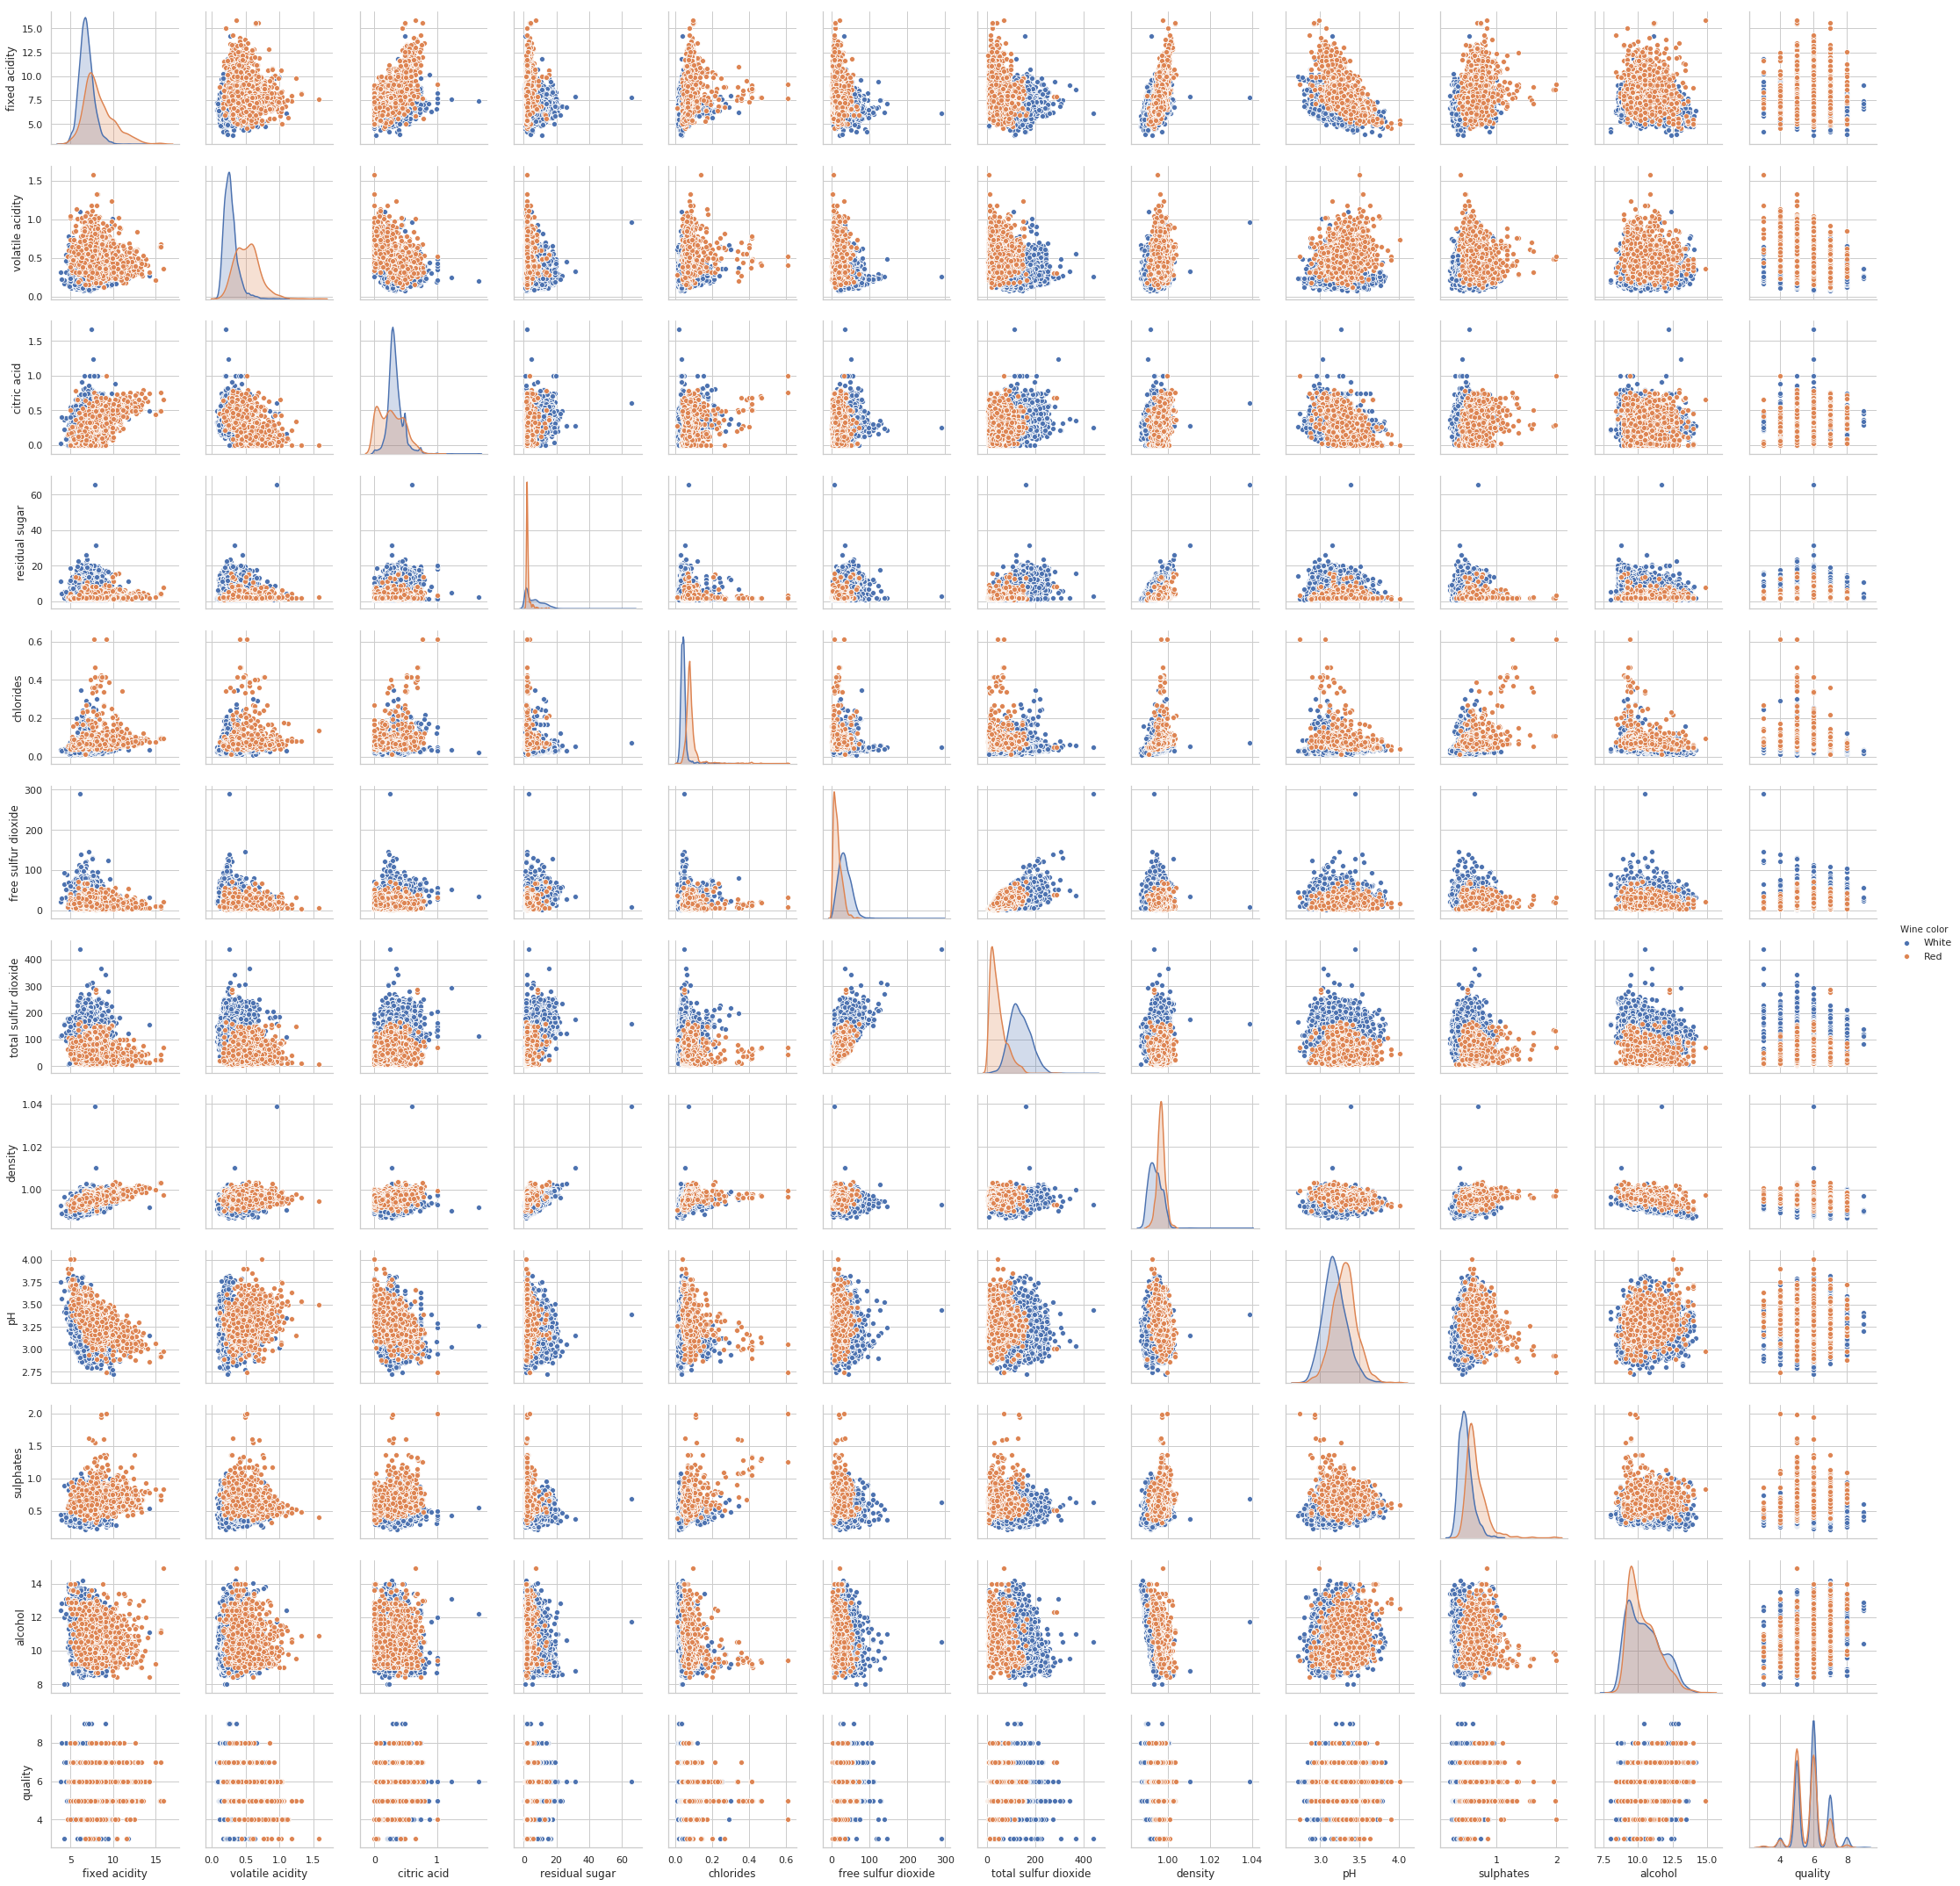

In [23]:
sns.pairplot(data=df_all.toPandas(), hue='Wine color')

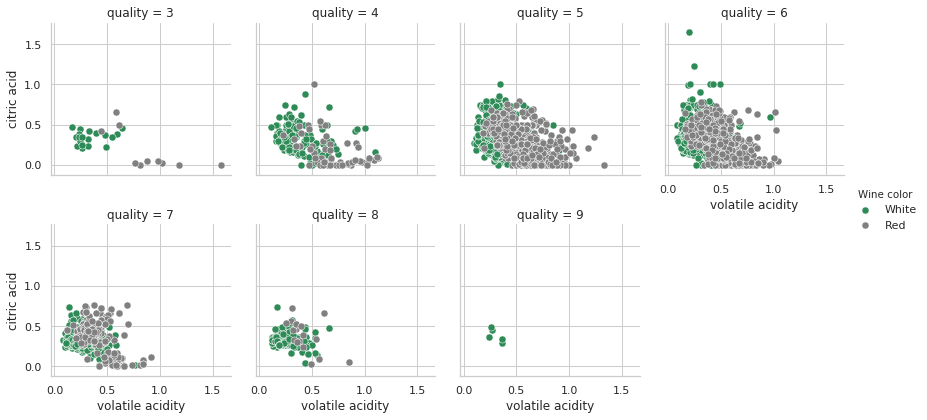

In [24]:
# scatter citric acid vs volatile acidity
import matplotlib.pyplot as plt
pal = {'White':"seagreen", 'Red':"gray"}
kws = dict(s=50, linewidth=.5, edgecolor="w")
g = sns.FacetGrid(df_all.toPandas(), col="quality", hue="Wine color", palette=pal, hue_order=['White', 'Red'], col_wrap=4)
g = (g.map(plt.scatter, "volatile acidity", "citric acid", **kws).add_legend())

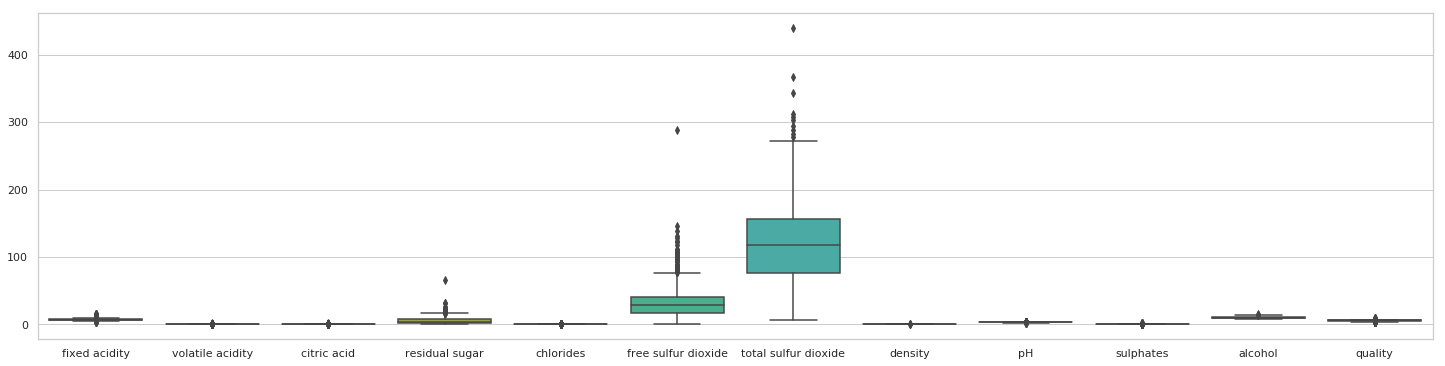

In [25]:
plt.figure(figsize=(25, 6))
sns.boxplot(data=df_all.toPandas())

In [26]:
def reject_outliers(data=pd.DataFrame(), min_thre=3, max_thre=6, filter_col=None):
    if not filter_col:
        filter_col = []

    for col in data.columns:
        if col in filter_col:
            continue
        data = data[~(operator.and_(min_thre * data[col].std() < np.abs(data[col]-data[col].mean()),
                      max_thre * data[col].std() > np.abs(data[col] - data[col].mean())))]
    return data

In [27]:
# remove outlier
df_for_o_w = df_w.select("fixed acidity", "volatile acidity", "citric acid", "residual sugar", "chlorides", "free sulfur dioxide",
                         "total sulfur dioxide", "density", "pH", "sulphates", "alcohol", "quality")
df_w_ro = spark.createDataFrame(reject_outliers(df_for_o_w.toPandas(), filter_col=["quality"]))
df_w_ro.toPandas().describe()

fixed acidity  volatile acidity  citric acid  residual sugar  \
count    4530.000000       4530.000000  4530.000000     4530.000000   
mean        6.842064          0.271542     0.327592        6.413951   
std         0.791639          0.087112     0.103242        5.023932   
min         4.400000          0.080000     0.000000        0.600000   
25%         6.300000          0.210000     0.270000        1.700000   
50%         6.800000          0.260000     0.310000        5.250000   
75%         7.300000          0.320000     0.380000        9.900000   
max        14.200000          1.100000     1.660000       65.800000   

         chlorides  free sulfur dioxide  total sulfur dioxide      density  \
count  4530.000000          4530.000000           4530.000000  4530.000000   
mean      0.044376            34.960265            137.813687     0.993981   
std       0.018362            15.988379             41.609207     0.002975   
min       0.012000             2.000000             19.000000     0.987110   
25%       0.035000            23.000000            108.000000     0.991700   
50%       0.043000            34.000000            134.000000     0.993700   
75%       0.050000            45.000000            167.000000     0.996075   
max       0.346000           289.000000            440.000000     1.038980   

                pH    sulphates      alcohol      quality  
count  4530.000000  4530.000000  4530.000000  4530.000000  
mean      3.187631     0.485296    10.531876     5.907506  
std       0.143120     0.105505     1.222818     0.869015  
min       2.790000     0.220000     8.400000     3.000000  
25%       3.090000     0.410000     9.500000     5.000000  
50%       3.180000     0.470000    10.400000     6.000000  
75%       3.280000     0.540000    11.400000     6.000000  
max       3.630000     0.820000    14.200000     9.000000

In [28]:
df_for_o_r = df_r.select("fixed acidity", "volatile acidity", "citric acid", "residual sugar", "chlorides", "free sulfur dioxide",
                         "total sulfur dioxide", "density", "pH", "sulphates", "alcohol", "quality")
df_r_ro = spark.createDataFrame(reject_outliers(df_for_o_r.toPandas(), filter_col=["quality"]))
df_r_ro.toPandas().describe()

fixed acidity  volatile acidity  citric acid  residual sugar  \
count    1447.000000       1447.000000  1447.000000     1447.000000   
mean        8.311334          0.523141     0.265556        2.411023   
std         1.641663          0.169512     0.192033        1.004150   
min         5.000000          0.120000     0.000000        1.200000   
25%         7.100000          0.390000     0.090000        1.900000   
50%         7.900000          0.520000     0.250000        2.200000   
75%         9.200000          0.630000     0.420000        2.600000   
max        13.500000          1.040000     0.790000       13.900000   

         chlorides  free sulfur dioxide  total sulfur dioxide      density  \
count  1447.000000          1447.000000           1447.000000  1447.000000   
mean      0.082473            14.956462             42.912232     0.996725   
std       0.027705             9.183102             28.199299     0.001701   
min       0.038000             1.000000              6.000000     0.991500   
25%       0.070000             7.000000             21.000000     0.995600   
50%       0.079000            13.000000             35.000000     0.996700   
75%       0.089000            20.000000             57.500000     0.997800   
max       0.415000            46.000000            136.000000     1.002100   

                pH    sulphates      alcohol      quality  
count  1447.000000  1447.000000  1447.000000  1447.000000  
mean      3.314900     0.645563    10.414225     5.645473  
std       0.142105     0.143376     1.010241     0.799000  
min       2.880000     0.330000     8.400000     3.000000  
25%       3.220000     0.550000     9.500000     5.000000  
50%       3.310000     0.620000    10.200000     6.000000  
75%       3.400000     0.720000    11.100000     6.000000  
max       3.750000     1.980000    13.500000     8.000000

In [29]:
# 0 presents the white wine while 1 presnts the red wine
df_w_ro = df_w_ro.withColumn("Wine color", lit("White"))

df_r_ro = df_r_ro.withColumn("Wine color", lit("Red"))

# union the df_white and df_red
df_all = df_w_ro.unionAll(df_r_ro)
df_all.show(5)

# data set size
df_all.count()


+-------------+----------------+-----------+--------------+---------+-------------------+--------------------+-------+----+---------+-------+-------+----------+
|fixed acidity|volatile acidity|citric acid|residual sugar|chlorides|free sulfur dioxide|total sulfur dioxide|density|  pH|sulphates|alcohol|quality|Wine color|
+-------------+----------------+-----------+--------------+---------+-------------------+--------------------+-------+----+---------+-------+-------+----------+
|          7.0|            0.27|       0.36|          20.7|    0.045|               45.0|               170.0|  1.001| 3.0|     0.45|    8.8|      6|     White|
|          6.3|             0.3|       0.34|           1.6|    0.049|               14.0|               132.0|  0.994| 3.3|     0.49|    9.5|      6|     White|
|          8.1|            0.28|        0.4|           6.9|     0.05|               30.0|                97.0| 0.9951|3.26|     0.44|   10.1|      6|     White|
|          7.2|            0.23|  

5977

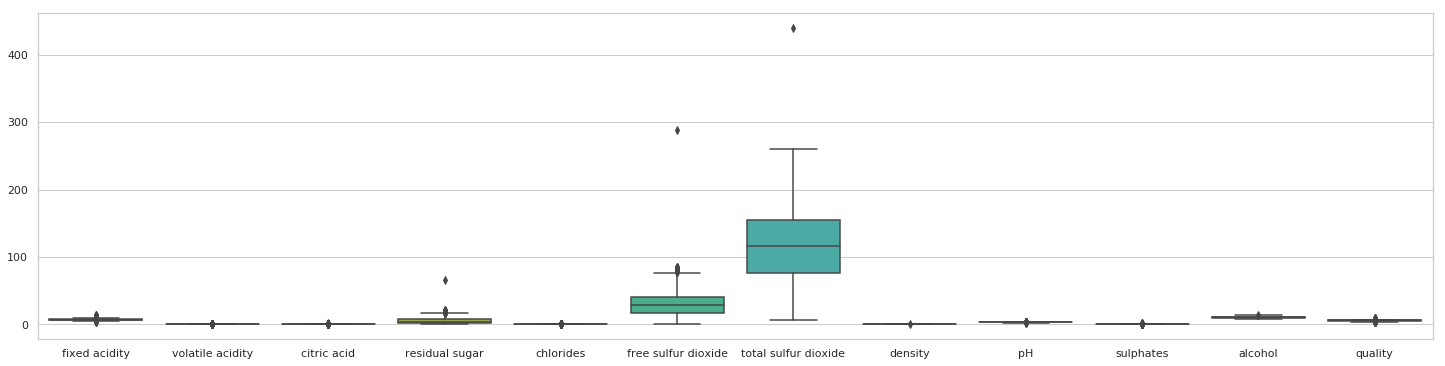

In [30]:
plt.figure(figsize=(25, 6))
sns.boxplot(data=df_all.toPandas())

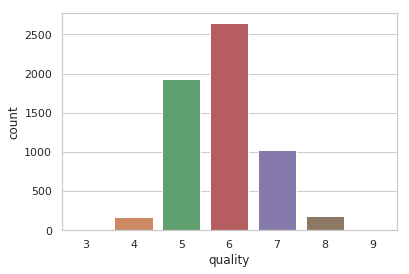

In [31]:
sns.countplot(x="quality", data=df_all.toPandas())

In [32]:
# data reclassify
df_re = df_all.withColumn("quality_N", when(df_all.quality < 6, 'bad').otherwise('good')).drop(
    df_all.quality).withColumnRenamed("quality_N", "quality")
df_re.show()

+-------------+----------------+-----------+--------------+---------+-------------------+--------------------+-------+----+---------+-------+----------+-------+
|fixed acidity|volatile acidity|citric acid|residual sugar|chlorides|free sulfur dioxide|total sulfur dioxide|density|  pH|sulphates|alcohol|Wine color|quality|
+-------------+----------------+-----------+--------------+---------+-------------------+--------------------+-------+----+---------+-------+----------+-------+
|          7.0|            0.27|       0.36|          20.7|    0.045|               45.0|               170.0|  1.001| 3.0|     0.45|    8.8|     White|   good|
|          6.3|             0.3|       0.34|           1.6|    0.049|               14.0|               132.0|  0.994| 3.3|     0.49|    9.5|     White|   good|
|          8.1|            0.28|        0.4|           6.9|     0.05|               30.0|                97.0| 0.9951|3.26|     0.44|   10.1|     White|   good|
|          7.2|            0.23|  

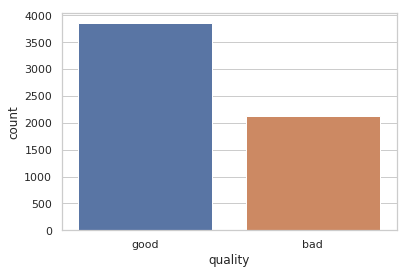

In [33]:
sns.countplot(x="quality", data=df_re.toPandas())

In [34]:
# data cleaning
print("Missing data:")
print(df_re.toPandas().isnull().sum())
df_dp_na = df_re.na.drop()
df_re.show()

Missing data:
fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
Wine color              0
quality                 0
dtype: int64
+-------------+----------------+-----------+--------------+---------+-------------------+--------------------+-------+----+---------+-------+----------+-------+
|fixed acidity|volatile acidity|citric acid|residual sugar|chlorides|free sulfur dioxide|total sulfur dioxide|density|  pH|sulphates|alcohol|Wine color|quality|
+-------------+----------------+-----------+--------------+---------+-------------------+--------------------+-------+----+---------+-------+----------+-------+
|          7.0|            0.27|       0.36|          20.7|    0.045|               45.0|               170.0|  1.001| 3.0|     0.45|    8.8|     White|

In [35]:
print('Count of duplicate records:{0}'.format(df_dp_na.count()-df_dp_na.distinct().count()))
df_dp_dup = df_dp_na.drop_duplicates()

Count of duplicate records:1106


                      fixed acidity  volatile acidity  citric acid  \
fixed acidity              1.000000          0.234176     0.332080   
volatile acidity           0.234176          1.000000    -0.417221   
citric acid                0.332080         -0.417221     1.000000   
residual sugar            -0.127838         -0.184259     0.141788   
chlorides                  0.362584          0.442456    -0.044575   
free sulfur dioxide       -0.301074         -0.378090     0.140474   
total sulfur dioxide      -0.361558         -0.444371     0.190602   
density                    0.463575          0.322853     0.070751   
pH                        -0.221605          0.285242    -0.329417   
sulphates                  0.332493          0.257307     0.038766   
alcohol                   -0.081801         -0.070852     0.036966   

                      residual sugar  chlorides  free sulfur dioxide  \
fixed acidity              -0.127838   0.362584            -0.301074   
volatile acidit

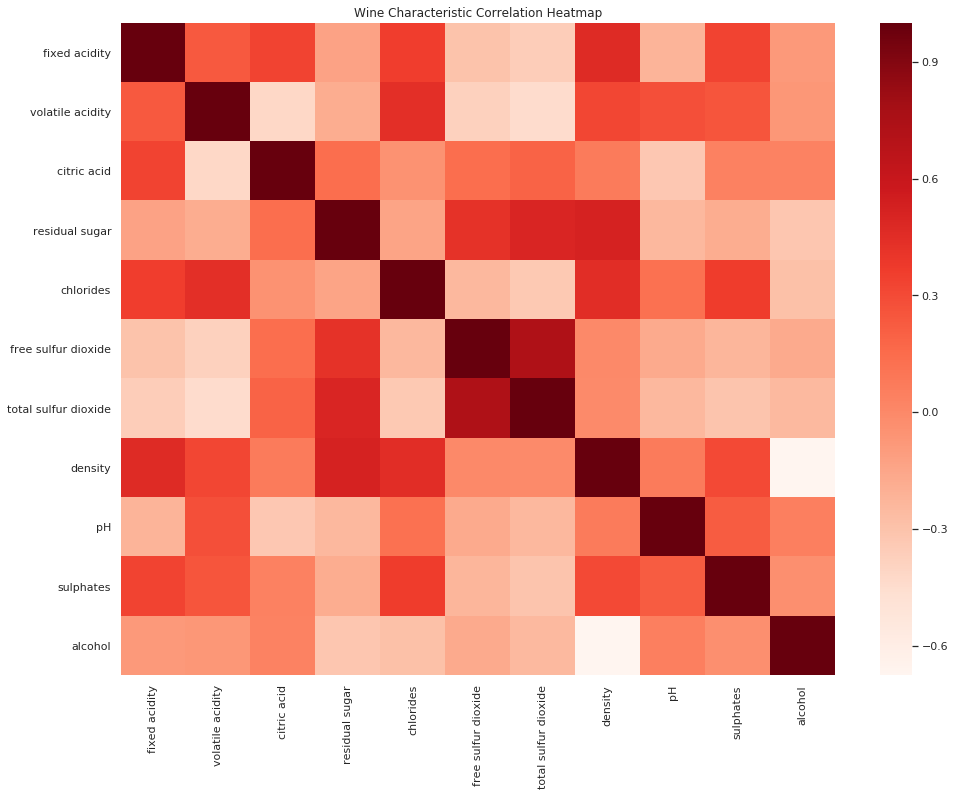

In [36]:
# data transforamtion as we can see from 
plt.subplots(figsize=(16,12))
ax = plt.axes()
ax.set_title("Wine Characteristic Correlation Heatmap")
corr = df_dp_dup.select([c for c in df_dp_dup.columns if c not in ['Wine color']]).toPandas().corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values,
            cmap="Reds")
print(corr)

In [37]:
# reduce the entire column "total sulfur dioxide"
df_trans = df_dp_dup.select([c for c in df_dp_dup.columns if c not in ['total sulfur dioxide']])
df_trans.toPandas().describe()

fixed acidity  volatile acidity  citric acid  residual sugar  \
count    4871.000000       4871.000000  4871.000000     4871.000000   
mean        7.198070          0.336065     0.312246        5.041326   
std         1.260511          0.158680     0.134142        4.461424   
min         4.400000          0.080000     0.000000        0.600000   
25%         6.400000          0.230000     0.250000        1.800000   
50%         7.000000          0.290000     0.310000        2.700000   
75%         7.700000          0.400000     0.390000        7.500000   
max        14.200000          1.100000     1.660000       65.800000   

         chlorides  free sulfur dioxide      density           pH  \
count  4871.000000          4871.000000  4871.000000  4871.000000   
mean      0.053992            29.638473     0.994477     3.224541   
std       0.027832            17.011023     0.002937     0.151468   
min       0.012000             1.000000     0.987110     2.790000   
25%       0.037000            16.000000     0.992120     3.120000   
50%       0.047000            28.000000     0.994600     3.220000   
75%       0.064000            41.000000     0.996700     3.330000   
max       0.415000           289.000000     1.038980     3.750000   

         sulphates      alcohol  
count  4871.000000  4871.000000  
mean      0.525687    10.563747  
std       0.133944     1.165155  
min       0.220000     8.400000  
25%       0.430000     9.583333  
50%       0.510000    10.400000  
75%       0.600000    11.400000  
max       1.980000    14.200000

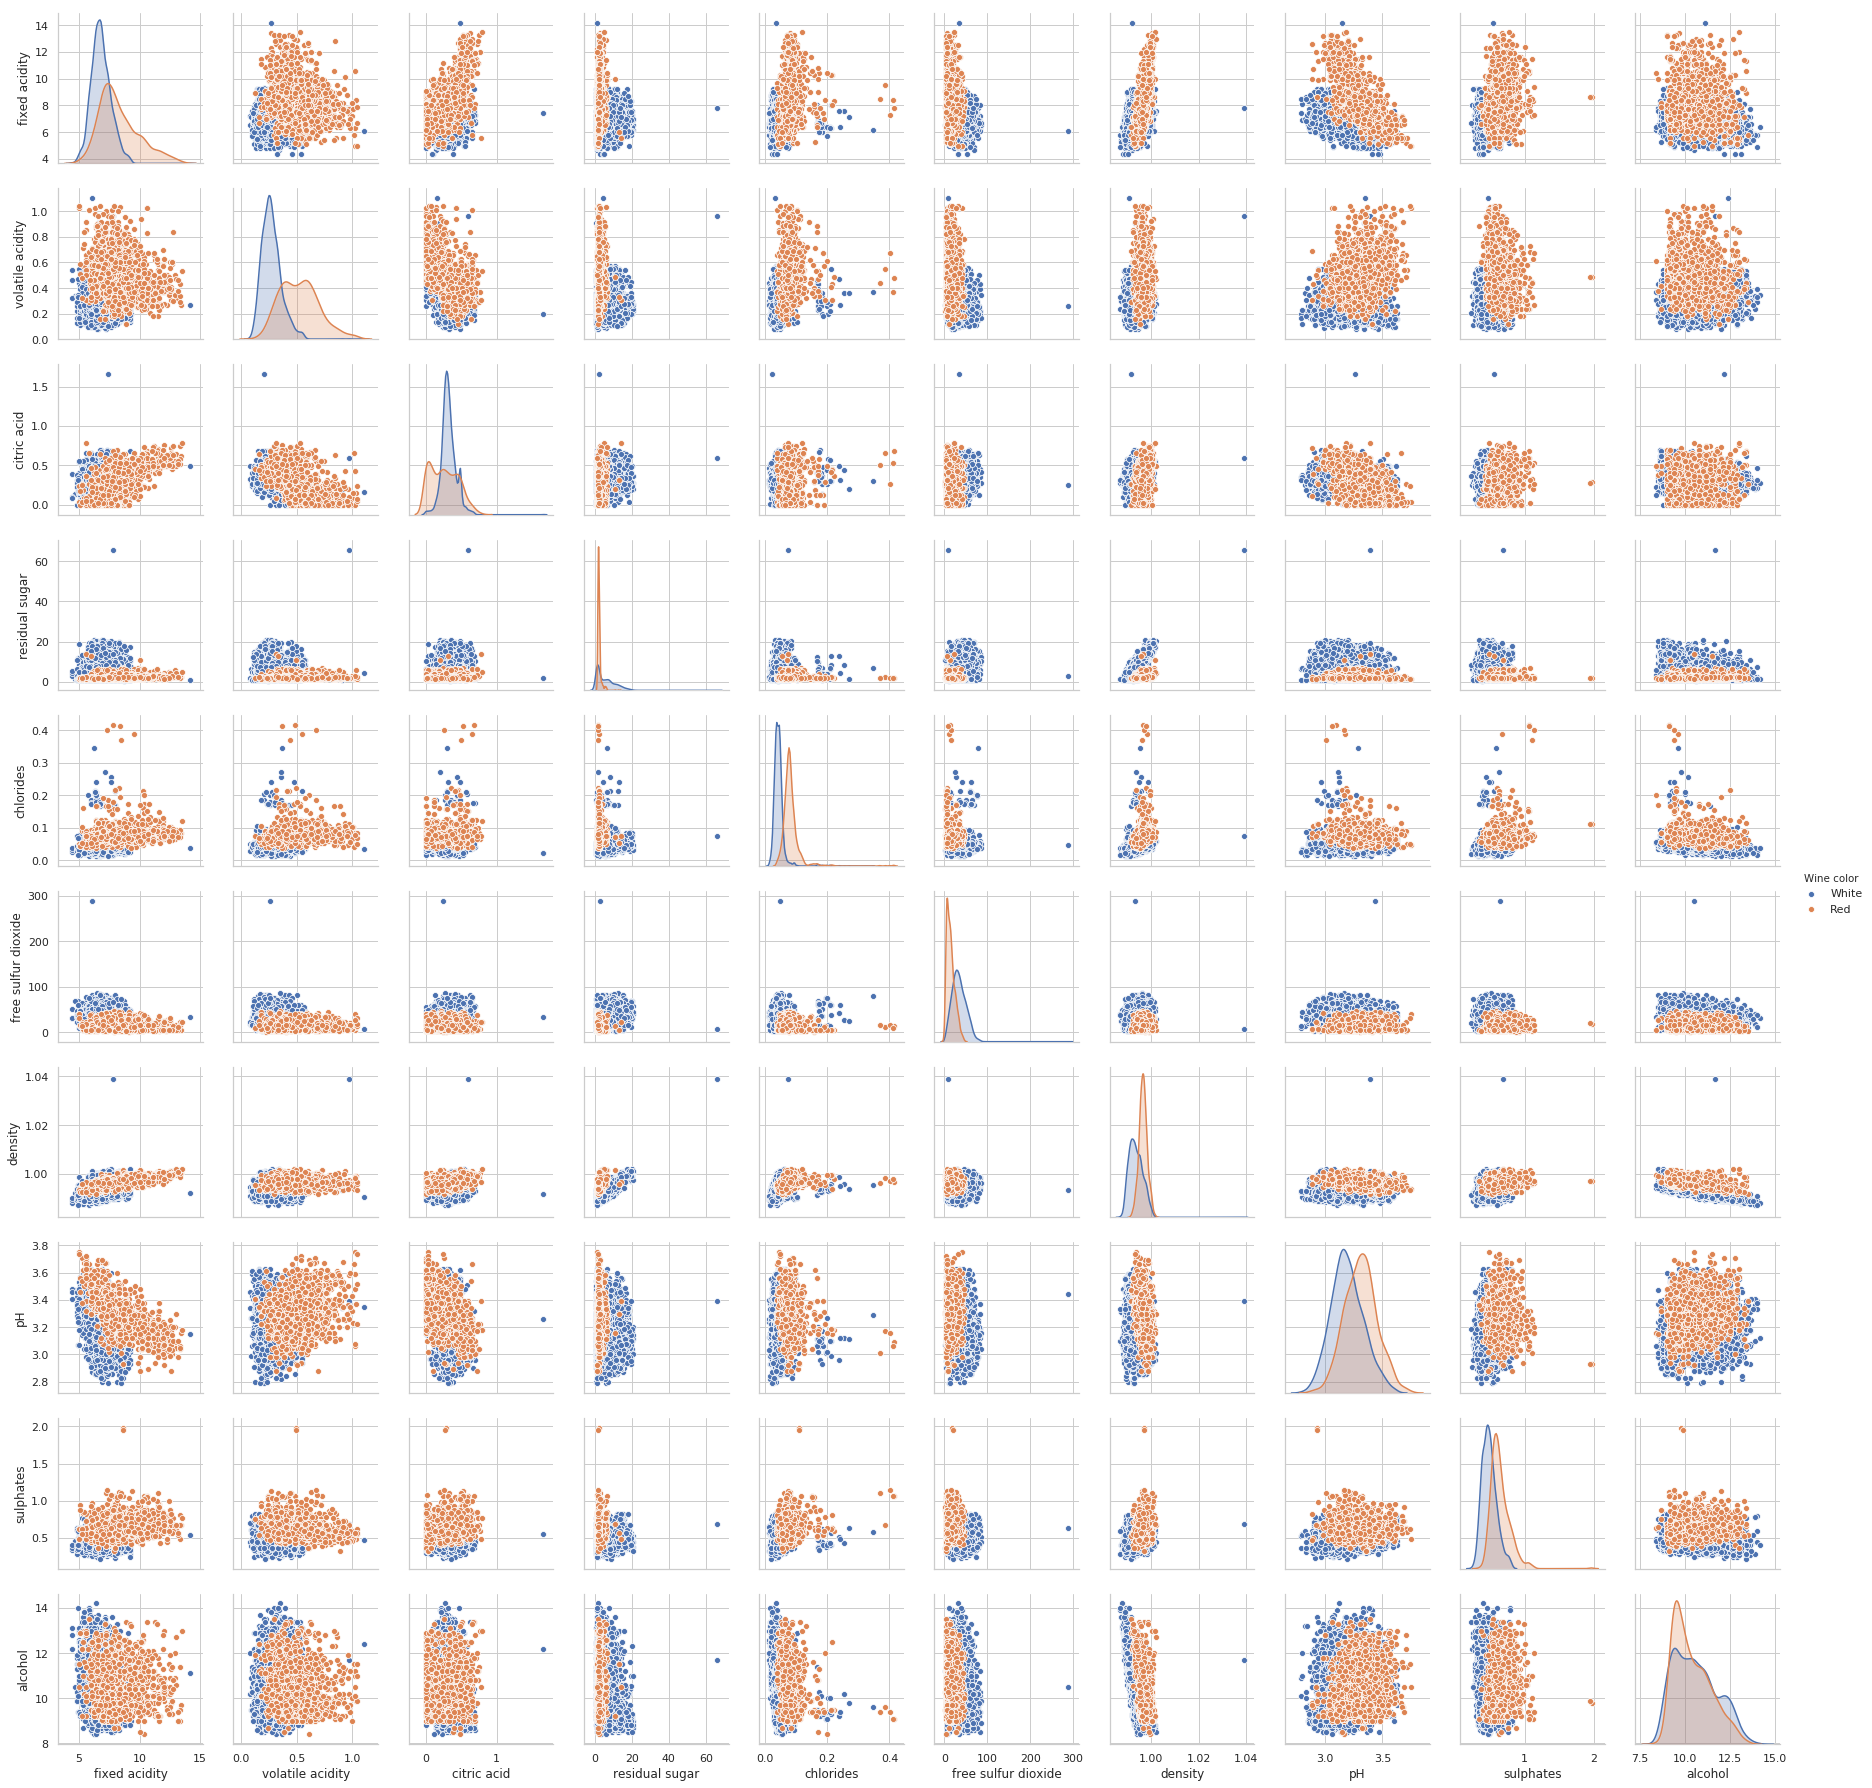

In [38]:
# citric acid vs volatile acidity
sns.pairplot(data=df_trans.toPandas(), hue='Wine color')

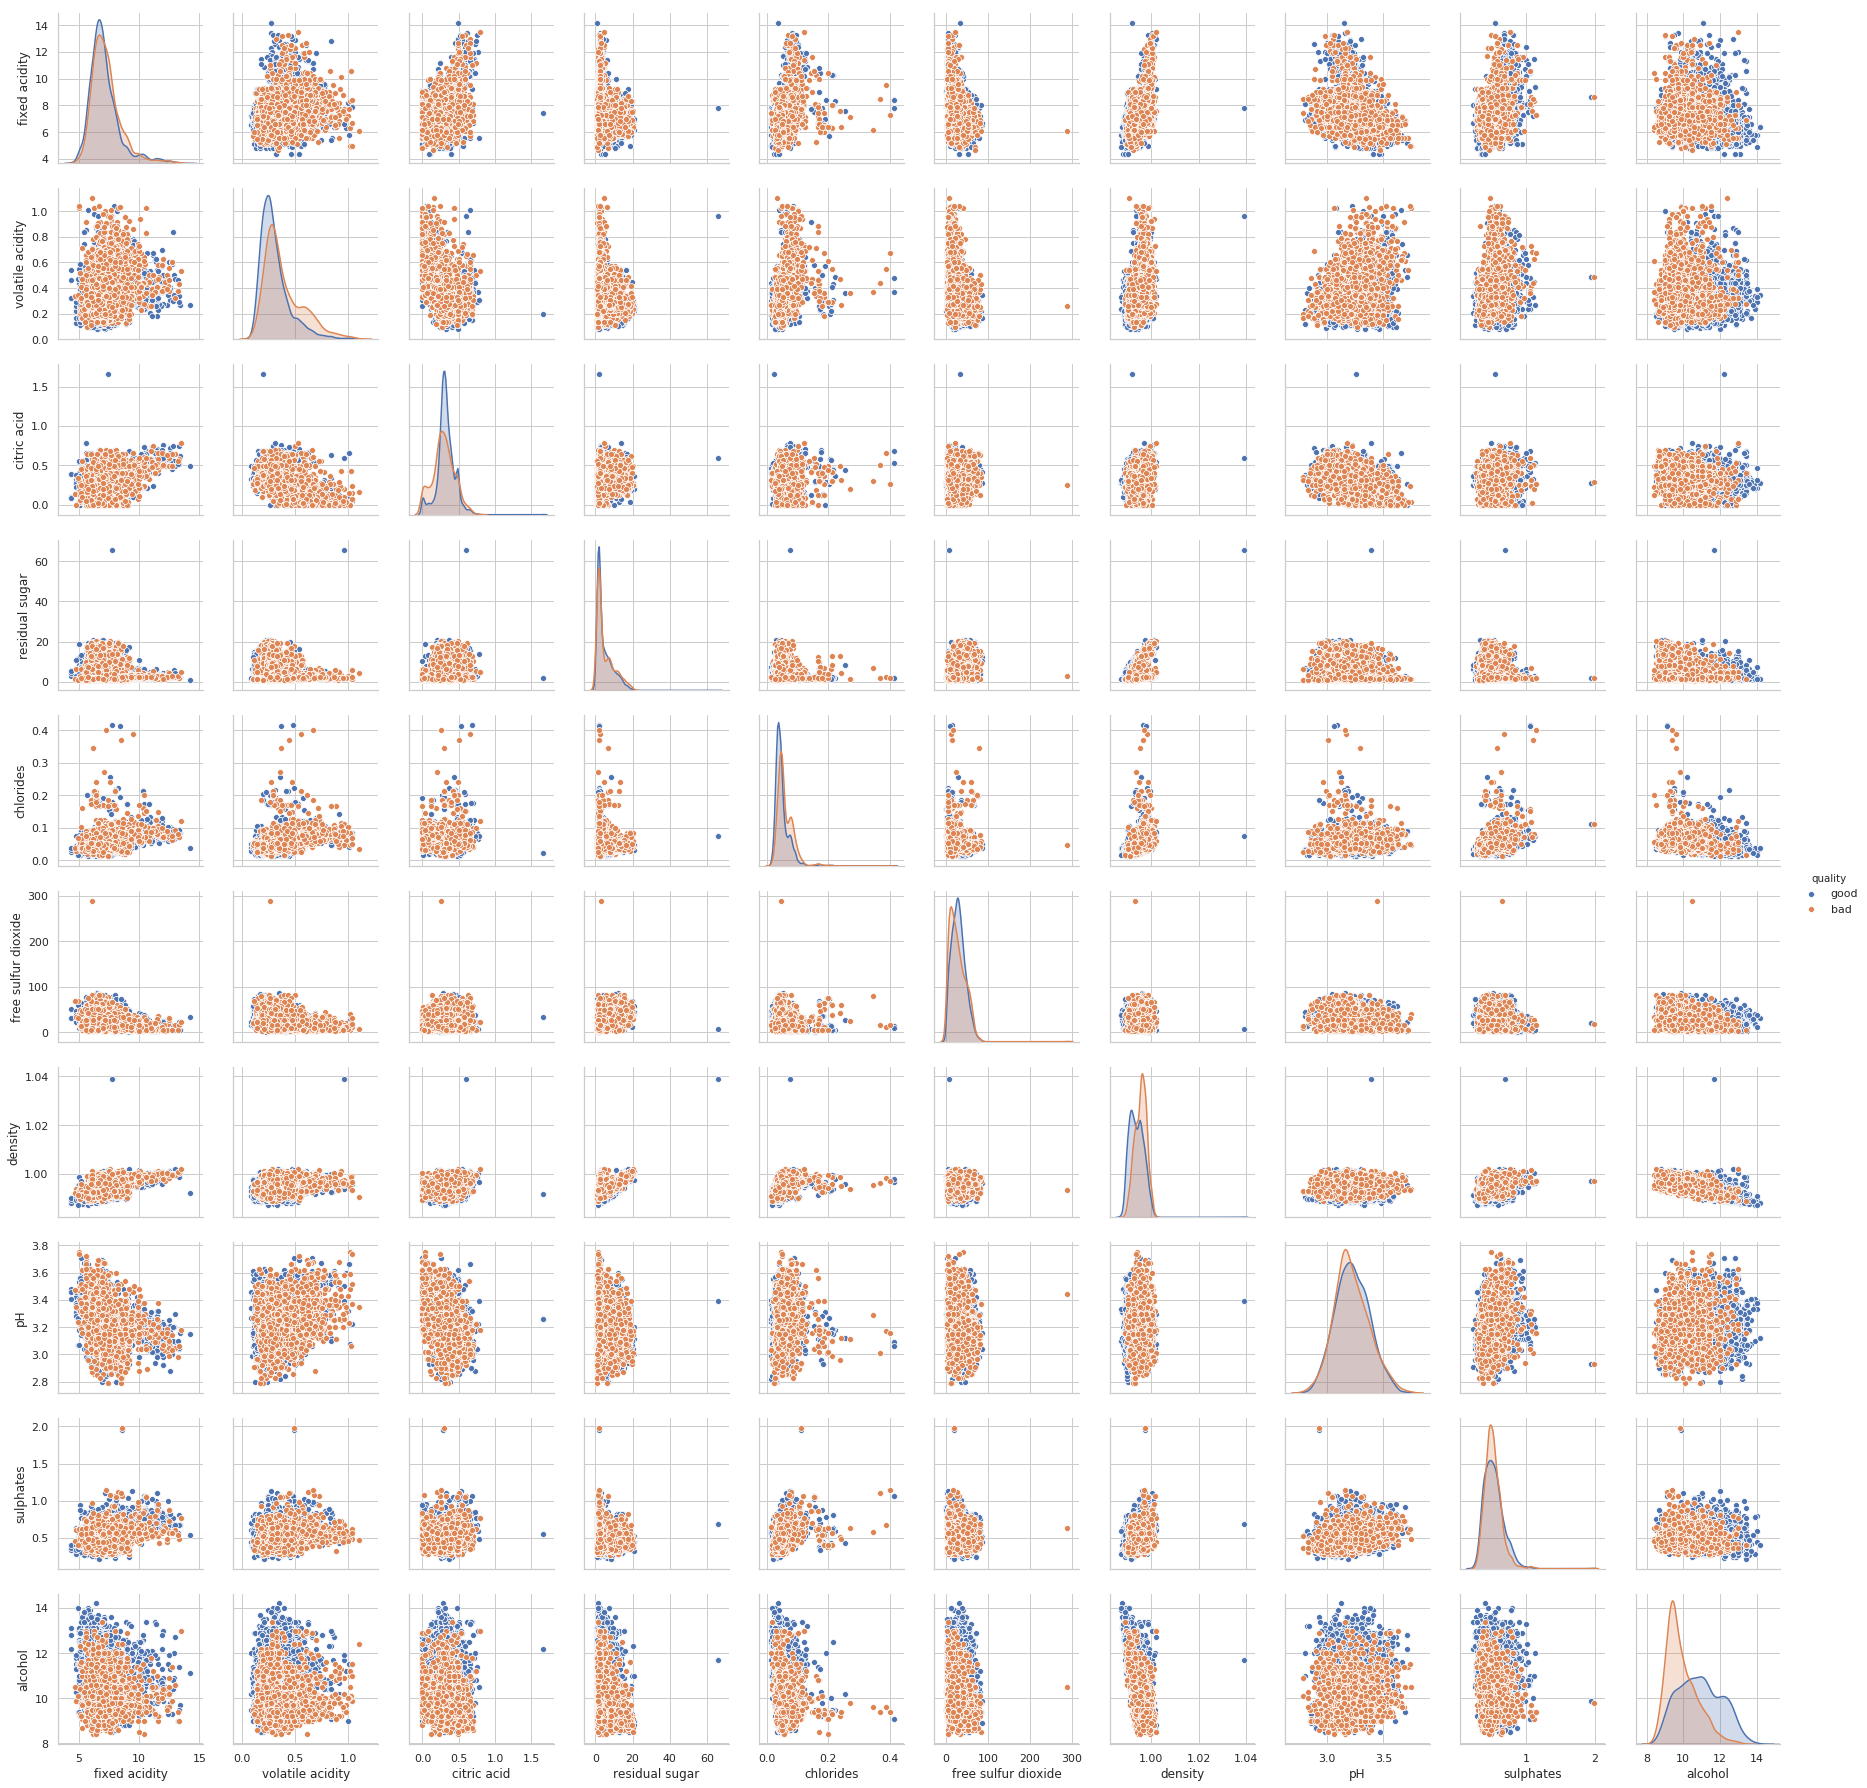

In [39]:
sns.pairplot(data=df_trans.toPandas(), hue='quality')

fixed acidity  volatile acidity  citric acid  residual sugar  \
count    4871.000000       4871.000000  4871.000000     4871.000000   
mean        7.200831          0.336697     0.312763        5.163375   
std         1.257394          0.162306     0.135072        4.535988   
min         4.400000          0.080000     0.000000        0.600000   
25%         6.400000          0.230000     0.250000        1.800000   
50%         7.000000          0.290000     0.310000        2.800000   
75%         7.700000          0.390000     0.390000        7.700000   
max        14.200000          1.100000     1.660000       65.800000   

         chlorides  free sulfur dioxide      density           pH  \
count  4871.000000          4871.000000  4871.000000  4871.000000   
mean      0.053538            30.165777     0.994534     3.225481   
std       0.026393            17.643337     0.002923     0.151659   
min       0.012000             1.000000     0.987110     2.790000   
25%       0.038000            17.000000     0.992230     3.120000   
50%       0.047000            28.000000     0.994610     3.220000   
75%       0.063000            41.000000     0.996750     3.330000   
max       0.415000           289.000000     1.038980     3.750000   

         sulphates      alcohol  
count  4871.000000  4871.000000  
mean      0.526145    10.551699  
std       0.132850     1.165721  
min       0.220000     8.400000  
25%       0.430000     9.500000  
50%       0.510000    10.400000  
75%       0.600000    11.300000  
max       1.980000    14.200000

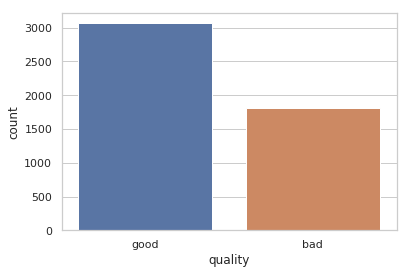

In [40]:
from sklearn.utils import resample
data_res = resample(df_trans.toPandas(), random_state=0)
data_res = spark.createDataFrame(data_res)
sns.countplot(x="quality", data=data_res.toPandas())
data_res.toPandas().describe()

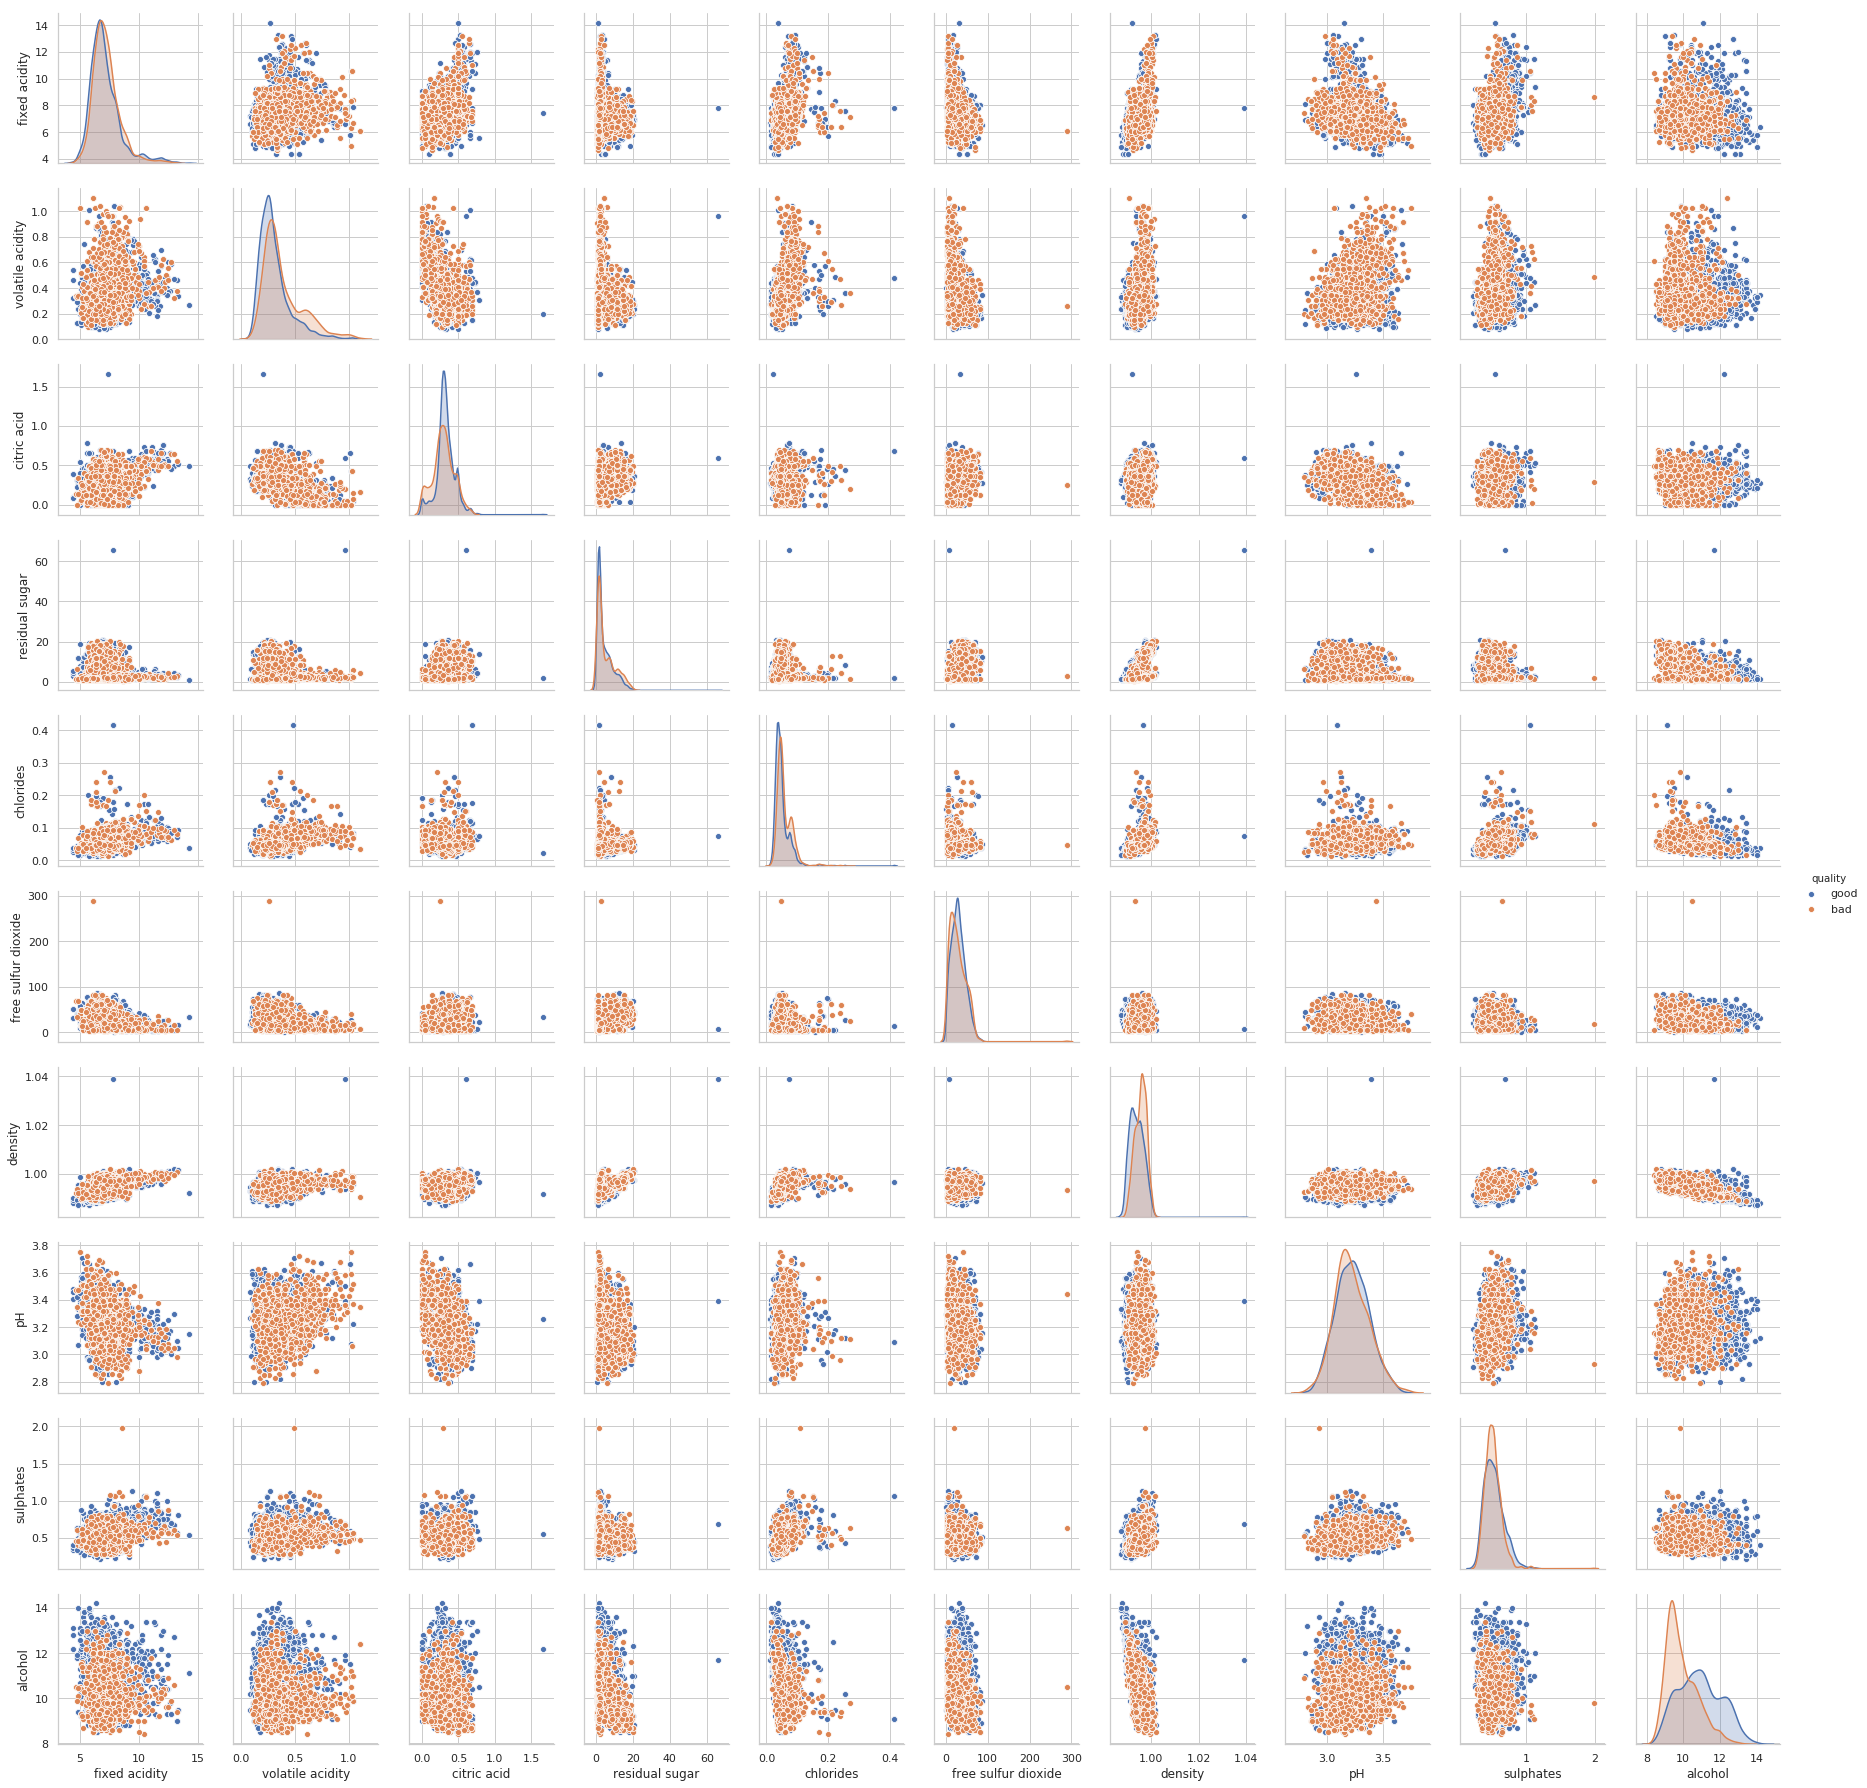

In [41]:
sns.pairplot(data=data_res.toPandas(), hue='quality')

In [42]:
# data_res.write.csv(os.path.join(os.getcwd(), 'clean_data.csv'), mode="overwrite", header=True)

In [43]:
# from sklearn.utils import resample
# data_res2 = resample(df_dp_dup.toPandas(), random_state=0)
# data_res2 = spark.createDataFrame(data_res2)
# sns.countplot(x="quality", data=data_res2.toPandas())
# data_res2.toPandas().describe()
# data_res2.write.csv(os.path.join(os.getcwd(), 'clean_data2.csv'), mode="overwrite", header=True)